In [177]:
from sklearn.datasets import make_blobs

def generate_first_dataset():
  X, y = make_blobs(n_samples=150,
    n_features=2,
    centers=10,
    cluster_std=0.5,
    shuffle=True,
    random_state=42)
  
  return X, y


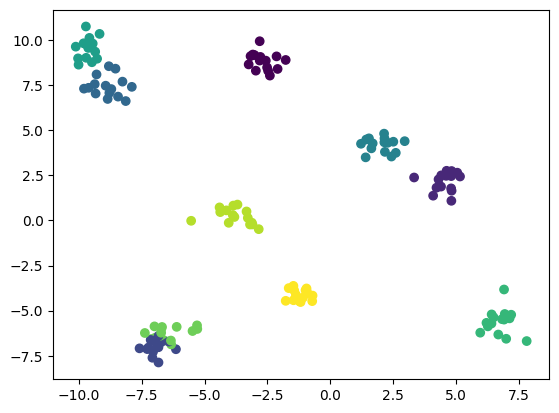

In [178]:

import matplotlib.pyplot as plt

# generowanie zbioru danych
X, y = generate_first_dataset()

# wyświetlenie wygenerowanego zbioru danych z podziałem na klastry
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()



### Technika *zasady łokcia*

In [179]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

# zakres liczby klastrów
k_values = range(1, 31)

# listy dla średnich miar jakości
avg_rand_scores = []
avg_mutual_info_scores = []

# listy dla odchyleń standardowych miar jakości
std_rand_scores = []
std_mutual_info_scores = []



In [180]:
def elbow_method(k_values, avg_rand_scores, avg_mutual_info_scores, std_rand_scores, std_mutual_info_scores):
  # klasteryzacja dla kolejnych wartości k
  for k in k_values:
    rand_scores = []
    mutual_info_scores = []

    # wielokrotne klasteryzowanie dla tej samej wartości k
    for i in range(10):
      kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42)
      kmeans.fit(X)

      labels = kmeans.labels_

      rand_scores.append(metrics.adjusted_rand_score(y, labels))
      mutual_info_scores.append(metrics.adjusted_mutual_info_score(y, labels))
    
    # średnia i odchylenie standardowe dla danej wartości k
    avg_rand_scores.append(np.mean(rand_scores))
    avg_mutual_info_scores.append(np.mean(mutual_info_scores))

    std_rand_scores.append(np.std(rand_scores))
    std_mutual_info_scores.append(np.std(mutual_info_scores))

elbow_method(k_values, avg_rand_scores, avg_mutual_info_scores, std_rand_scores, std_mutual_info_scores) 


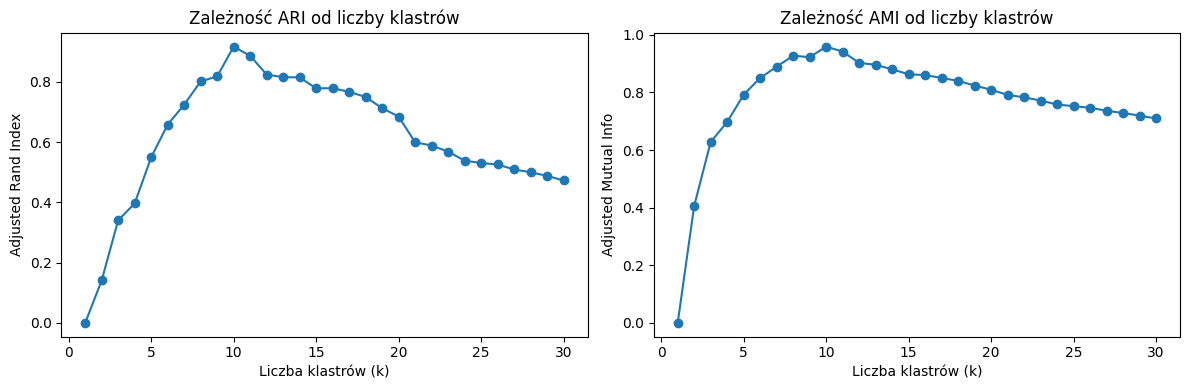

In [181]:
# wykresy zależności miar jakości od liczby klastrów

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(k_values, avg_rand_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Zależność ARI od liczby klastrów')

plt.subplot(122)
plt.plot(k_values, avg_mutual_info_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Adjusted Mutual Info')
plt.title('Zależność AMI od liczby klastrów')

plt.tight_layout()
plt.show()

In [182]:
# Wypisanie uzyskanych wartości k dla każdej miary jakości
best_k_ari = np.argmax(avg_rand_scores) + 1
best_k_ami = np.argmax(avg_mutual_info_scores) + 1

print(f"Najlepsza wartość k dla ARI: {best_k_ari}")
print(f"Najlepsza wartość k dla AMI: {best_k_ami}")


Najlepsza wartość k dla ARI: 10
Najlepsza wartość k dla AMI: 10


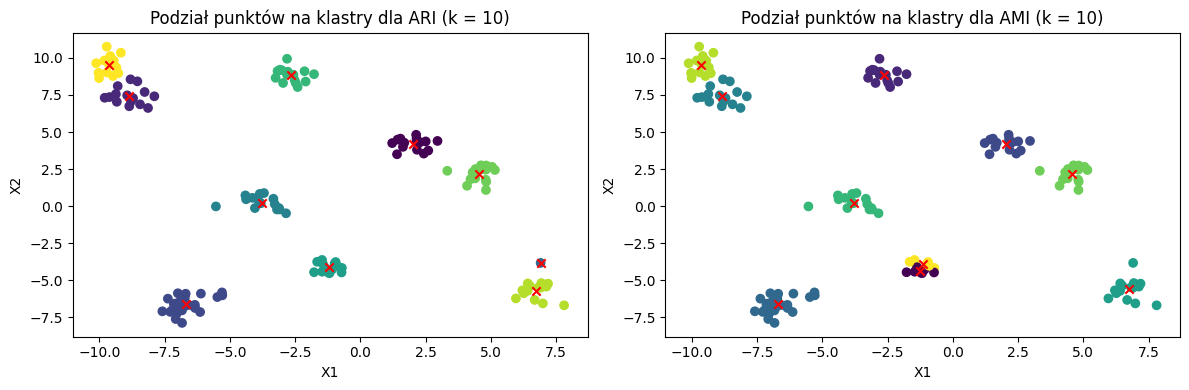

In [183]:
# wykonanie klasteryzacji dla optymalnych wartości k
best_kmeans_ari = KMeans(n_clusters=best_k_ari, init='k-means++', n_init=1)
best_kmeans_ari.fit(X)
labels_ari = best_kmeans_ari.labels_

best_kmeans_ami = KMeans(n_clusters=best_k_ami, init='k-means++', n_init=1)
best_kmeans_ami.fit(X)
labels_ami = best_kmeans_ami.labels_

# Wykres podziału punktów na klastry dla ARI
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=labels_ari, cmap='viridis')
plt.scatter(best_kmeans_ari.cluster_centers_[:, 0], best_kmeans_ari.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Podział punktów na klastry dla ARI (k = {})'.format(best_k_ari))

# Wykres podziału punktów na klastry dla AMI
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=labels_ami, cmap='viridis')
plt.scatter(best_kmeans_ami.cluster_centers_[:, 0], best_kmeans_ami.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Podział punktów na klastry dla AMI (k = {})'.format(best_k_ami))

plt.tight_layout()
plt.show()


- **k** jest takie same w obu przypadkach
- **k** jest zgodne z podanym przy generacji
- Podział na **k** klastry wydaje się, że "ma sens". Wygenerowany zbiór sam posiada lekko nakładające sie klastry, więc powyższy podział jest jak najbardziej poprawny.

### Adaptywne hierarchiczne dobieranie liczby klastrów

In [186]:
from scipy.stats import normaltest

# współczynniki prostej przechodzącej przez dwa punkty
def getLineEquation(p1, p2):
    a = (p2[1] - p1[1]) / (p2[0] - p1[0])
    b = p1[1] - a * p1[0]

    return a, b


# obliczenie odległości punktu od prostej
def getDistanceFromLine(point, line):
    a, b = line
    x, y = point

    return abs(a * x - y + b) / np.sqrt(a**2 + 1)

# rzutowanie punktu na prostą
def getCrossoverPoint(line, point):
    a, b = line
    x, y = point

    x0 = (x + a * y - a * b) / (a**2 + 1)
    y0 = (a * x + a**2 * y - a**2 * b) / (a**2 + 1) + b

    return x0, y0

def getPointBetweenPoints(p1, p2):
    return (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2


# obliczenie odległości punktu od centroidu (punkty poniżej prostopadłej do prostej przechodzącej przez centroid mają ujemną odległość)
def getDistanceFromCentroid(point, centroid):
    dist = np.sqrt((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2)
    if point[1] < centroid[1]:
        dist = -dist
    
    return dist

# sprawdzenie normalności rozkładu po rzutowaniu na prostą
def check_normality(X, threshold):
    _, p = normaltest(X)
    return p > threshold

# Funkcja do rekurencyjnego podziału klastrów na podklastry
def recursive_cluster_split(X, threshold, min_cluster_size, cluster_iterator=0):
    # jeśli liczba punktów w klastrze jest mniejsza niż minimalny rozmiar klastra, to zwracamy listę zawierającą tylko ten klaster
    if len(X) < min_cluster_size:
        temp_kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1)
        temp_kmeans.fit(X)
        centroid = temp_kmeans.cluster_centers_[0]
        return np.full(len(X), cluster_iterator), [centroid]

    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=1)
    kmeans.fit(X)

    labels = kmeans.labels_
    unique_labels = np.unique(labels) # powinny być dwa
    assert len(unique_labels) == 2

    # centroidy klastrów
    centroids = kmeans.cluster_centers_

    # linia prosta przechodząca przez centroidy
    line = getLineEquation(centroids[0], centroids[1])

    # rzutowanie punktów na prostą
    projected_points = []
    for point in X:
        projected_points.append(getCrossoverPoint(line, point))
    
    # generujemy wspólny środek dla obu klastrów
    center = getPointBetweenPoints(centroids[0], centroids[1])

    # obliczamy odległość każdego punktu od środka
    X_dist = []
    for point in projected_points:
        X_dist.append(getDistanceFromCentroid(point, center))

    # sprawdzamy normalność rozkładu odległości
    if not check_normality(X_dist, threshold):
        X_a = X[labels == unique_labels[0]]
        X_b = X[labels == unique_labels[1]]

        new_cluster_iterator = cluster_iterator * 2 + 1
        labels_a, centroids_a = recursive_cluster_split(X_a, threshold, min_cluster_size, new_cluster_iterator)
        labels_b, centroids_b = recursive_cluster_split(X_b, threshold, min_cluster_size, new_cluster_iterator + 1)

        labels[labels == unique_labels[0]] = labels_a
        labels[labels == unique_labels[1]] = labels_b
        centroids = np.concatenate((centroids_a, centroids_b), axis=0)
    else:
        temp_kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1)
        temp_kmeans.fit(X)
        centroid = temp_kmeans.cluster_centers_[0]
        return np.full(len(X), cluster_iterator), [centroid]
    
    return labels, centroids


[15 12 10 17 19 10 17 11  6 10 17 15 11 18 19 11 12 10 10 10 15 12 17 16
 19 12 19 17 12 10 12 20  6  6 16 19 15 20 15 11  6 16 17 15 20 11 16 10
 10  6 11 19 19 12 16 17 17 17 20  6 16 10 17 12 16 20 20  6  6 11 11 19
 17 17 11 20 11 16 17 16 12 20 15 17 20 17  6 17 11 20 18 15 20  6 15 17
 17 19 16 20 19 12 18 16 17  6 12  6 10 19 17 15 20 15 15 15 19 20 17 10
 11 17  6 16 10  6 16 12 17 17 17 12 12 16 19 10 20 18 17 11 12 16 19  6
 11 15 10 19 15 11]
[[-1.19321394 -4.11297451]
 [-3.77493217  0.2270966 ]
 [-6.87033917 -6.72867407]
 [-5.54643293 -5.96476965]
 [ 4.5490673   2.15235833]
 [ 2.0183141   4.19715562]
 [ 6.74045364 -5.61808495]
 [-9.63718987  9.5454271 ]
 [-8.85304934  7.43429612]
 [-2.6575769   8.8278755 ]]


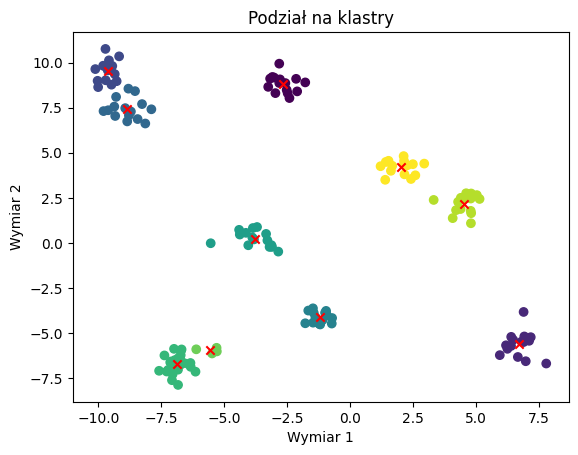

In [187]:
# parametry algorytmu
threshold = 0.05  # prog czułości testu normalności
min_cluster_size = 20  # minimalna liczba punktów w klastrze

# wywołanie rekurencyjnego podziału klastrów
labels, centroids = recursive_cluster_split(X, threshold, min_cluster_size)
print(labels)
print(centroids)

# mapujemy etykiety klastrów na etykiety od 0 do n-1
unique_labels = np.unique(labels)
for i, label in enumerate(unique_labels):
    labels[labels == label] = i


# wykres podziału na klastry
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.title("Podział na klastry")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.show()


In [188]:
# wyświetlenie liczby klastrów i ich rozmiarów
unique_labels, cluster_sizes = np.unique(labels, return_counts=True)
num_clusters = len(unique_labels)
print(f"Liczba klastrów: {num_clusters}")
print("Rozmiary klastrów:")
for i, label in enumerate(unique_labels):
    print(f"Klaster {label}: {cluster_sizes[i]}")

# obliczenie wybranych miar jakości
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

true_labels = y  # prawdziwe etykiety klastrów (dla porównania)

rand_index = adjusted_rand_score(true_labels, labels)
mutual_info = adjusted_mutual_info_score(true_labels, labels)

print(f"Adjusted Rand Index: {rand_index}")
print(f"Adjusted Mutual Information: {mutual_info}")


Liczba klastrów: 10
Rozmiary klastrów:
Klaster 0: 15
Klaster 1: 15
Klaster 2: 15
Klaster 3: 15
Klaster 4: 15
Klaster 5: 15
Klaster 6: 26
Klaster 7: 4
Klaster 8: 15
Klaster 9: 15
Adjusted Rand Index: 0.8955494212469939
Adjusted Mutual Information: 0.9549359843878408


### Piłkarzyki

In [173]:
import pandas as pd

# ładujemy dane z pliku
df = pd.read_csv('players.csv', sep=',')

# good columns (38-105)




Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)


/tmp/ipykernel_3015/2784103904.py:4: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('players.csv', sep=',')
